# Imports and setup

In [90]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast, pipeline, AutoTokenizer, AutoModel
from datasets import load_dataset, ClassLabel
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import nlp
import matplotlib.pyplot as plt

- Small-E-Czech is a transformer trained on Czech corpora by Seznam

In [91]:
model_name = "Seznam/small-e-czech"
# pipe = pipeline(task="text-classification", model=model_name)

# Data loading, manipulation and exploration

In [92]:
# load data into pandas

# df = pd.read_csv('data/sample_data.csv')
# df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

# df_train.to_csv('data/sample_data_train.csv', index=False)
# df_test.to_csv('data/sample_data_test.csv', index=False)

df_train = pd.read_csv('data/sample_data_train.csv')
df_test = pd.read_csv('data/sample_data_test.csv')

df_train.head(10)

,text,label
0,V zoologické zahradě měli lachtana.,1
1,"Když budu celý život tvrdě pracovat, tak si st...",0
2,Zrzavá liška běžela v lese.,1
3,Dneska jsem viděl jak soused kácel strom.,0
4,Matematika je lepší než zeměpis.,0
5,Slepice snáší vejce.,1
6,Včera večer jsme na procházce krmili labutě.,1
7,Nasadil jsem si brýle.,0
8,Večeřeli jsme v kuchyni.,0
9,Kohout ráno všechny vzbudil.,1


In [ ]:
# load into hugging_face dataset object and cast label as target

ds = load_dataset('csv', data_files={'train': 'data/sample_data_train.csv', 'test': 'data/sample_data_test.csv'})
label_features = ClassLabel(names=["není zvíře", "je zvíře"])

ds['train'] = ds['train'].cast_column("label", label_features)
ds['test'] = ds['test'].cast_column("label", label_features)

In [18]:
# examine values

print(ds['train'].features)
print(ds['train'][0])
print(ds['test'].features)
print(ds['test'][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['není zvíře', 'je zvíře'], id=None)}
{'text': 'V zoologické zahradě měli lachtana.', 'label': 1}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['není zvíře', 'je zvíře'], id=None)}
{'text': 'Pohladil jsem kočku.', 'label': 1}


In [19]:
# features = ds.features.copy()
# features["label"] = ClassLabel(names=["není zvíře", "je zvíře"])
# def adjust_labels(batch):
# #     batch["label"] = [sentiment + 1 for sentiment in batch["label"]]
#     return batch
# ds = ds.map(adjust_labels, batched=True, features=features)
# ds
# ds.features

In [20]:
# display dataset as pandas dataframe

ds['train'].set_format(type="pandas")
df = ds['train'][:]
df.head()

,text,label
0,V zoologické zahradě měli lachtana.,1
1,"Když budu celý život tvrdě pracovat, tak si st...",0
2,Zrzavá liška běžela v lese.,1
3,Dneska jsem viděl jak soused kácel strom.,0
4,Matematika je lepší než zeměpis.,0


In [21]:
# map labels to label name

def label_int2str(row):
    return ds["train"].features["label"].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,V zoologické zahradě měli lachtana.,1,je zvíře
1,"Když budu celý život tvrdě pracovat, tak si st...",0,není zvíře
2,Zrzavá liška běžela v lese.,1,je zvíře
3,Dneska jsem viděl jak soused kácel strom.,0,není zvíře
4,Matematika je lepší než zeměpis.,0,není zvíře


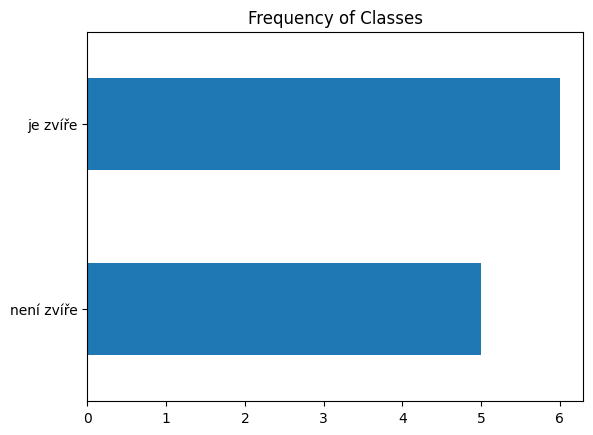

In [22]:
# displaying class frequencies

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

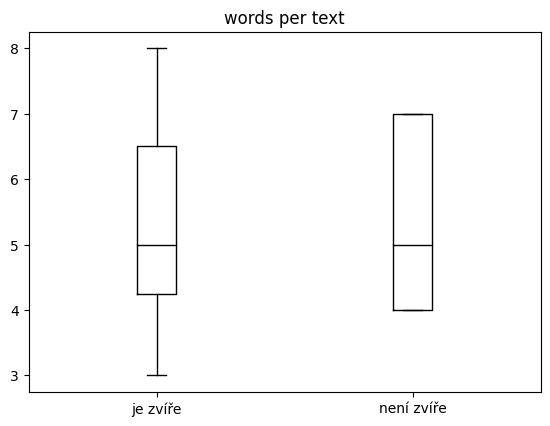

In [23]:
# displaying boxplots for word frequencies per class

df["words per text"] = df["text"].str.split().apply(len)
df.boxplot("words per text", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

# Tokenization

In [73]:
tokenizer = AutoTokenizer.from_pretrained(model)

# tokenized_data_train = 
tokenizer(ds['train']['text'], return_tensors="tf", padding=True, truncation=True)
# labels_train = np.array(ds['train']['label'])
# tokenized_data_test = tokenizer(ds['test']['text'], return_tensors="tf", padding=True, truncation=True)
# labels_test = np.array(ds['test']['label'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': <tf.Tensor: shape=(11, 18), dtype=int32, numpy=
array([[    2,    63,  7501,  5368,  6695,  1931, 16102,   154, 10097,
          145,    18,     3,     0,     0,     0,     0,     0,     0],
       [    2,   593,  2631,  1912,  1764, 18973,  4844,    16,   316,
          354,  1633,  6691, 22633, 13960,  1352,  1971,    18,     3],
       [    2,  3596, 11583,   155, 20550, 11871,   246,    63,  9110,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5462,   409,  6006,   334,  4777,  2049,  6976,  6305,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2, 16537,   252,  2082,   688, 21387,    18,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2, 22251, 14416,   300,  8036,    18,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5353,  2525,   594,   242, 15029,   248,  7024,   249,
        1

In [57]:
# attention mask umožňuje ignorovat padding
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(11, 18), dtype=int32, numpy=
array([[    2,    63,  7501,  5368,  6695,  1931, 16102,   154, 10097,
          145,    18,     3,     0,     0,     0,     0,     0,     0],
       [    2,   593,  2631,  1912,  1764, 18973,  4844,    16,   316,
          354,  1633,  6691, 22633, 13960,  1352,  1971,    18,     3],
       [    2,  3596, 11583,   155, 20550, 11871,   246,    63,  9110,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5462,   409,  6006,   334,  4777,  2049,  6976,  6305,
           18,     3,     0,     0,     0,     0,     0,     0,     0],
       [    2, 16537,   252,  2082,   688, 21387,    18,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2, 22251, 14416,   300,  8036,    18,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    2,  5353,  2525,   594,   242, 15029,   248,  7024,   249,
        1

In [59]:
# navrácení tokenů k id
tokens = tokenizer.convert_ids_to_tokens(tokenized_data_train[0].ids)
tokens

['[CLS]',
 'v',
 'zoo',
 '##logické',
 'zahradě',
 'měli',
 'lac',
 '##h',
 '##tan',
 '##a',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [61]:
# tisk jako string
tokenizer.convert_tokens_to_string(tokens)

'[CLS] v zoologické zahradě měli lachtana. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [62]:
# počet tokenů ve slovníku
tokenizer.vocab_size

30522

In [64]:
# maximální délka vektoru
# (... mám o tom nějaké pochybnosti ....)

tokenizer.model_max_length

1000000000000000019884624838656

In [66]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [87]:
# tokenizace celého datasetu
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized = ds.map(tokenize, batched=True, batch_size=None)
tokenized

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6
    })
})

# Modelling

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model).to(device)

OSError: Can't load the configuration of 'ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (3): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (4): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (5): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (6): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (7): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (8): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (9): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (10): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (11): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
)'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure 'ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (2): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (3): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (4): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (5): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (6): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (7): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (8): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (9): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (10): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (11): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): ElectraIntermediate(
          (dense): Linear(in_features=256, out_features=1024, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ElectraOutput(
          (dense): Linear(in_features=1024, out_features=256, bias=True)
          (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
)' is the correct path to a directory containing a config.json file

In [ ]:
# tensorflow is also available
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_name)

In [89]:
text = "Toto je zkušební text"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(outputs.last_hidden_state.size())

Input tensor shape: torch.Size([1, 6])
BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 3.6099e-01,  5.5451e-05, -1.2910e-04,  ...,  2.7867e-04,
           4.9307e-01, -1.3343e-04],
         [-1.9553e-01, -3.0069e-04, -1.0528e-04,  ...,  9.9561e-05,
          -1.1577e+00, -1.9735e-04],
         [-4.4455e-01, -4.6349e-04, -9.3824e-05,  ...,  3.3250e-04,
           1.7377e-01, -1.3628e-04],
         [-2.3091e-02, -2.4707e-04, -7.6978e-05,  ...,  6.1547e-04,
           6.3975e-01, -1.4361e-04],
         [ 1.0250e+00, -2.7454e-04, -7.3393e-05,  ...,  7.0218e-04,
           4.0733e-01, -2.5776e-04],
         [ 3.6190e-01,  5.5545e-05, -1.2914e-04,  ...,  2.7877e-04,
           4.9256e-01, -1.3352e-04]]]), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
torch.Size([1, 6, 256])


<i>"Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 256-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:"</i>

In [80]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 256])

In [81]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [85]:
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# token_type_ids?

In [86]:
# hidden states
hidden = tokenized.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

AttributeError: 'list' object has no attribute 'to'

In [12]:
tf_train = train_ds.to_tf_dataset(
    columns=["text"],
    label_cols=["label"],
    batch_size=4,
    shuffle=True)

tf_test = test_ds.to_tf_dataset(
    columns=["text"],
    label_cols=["label"],
    batch_size=4,
    shuffle=True)

In [13]:
tf_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [4]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [4]:
tokenized_data_train = tokenizer(train_ds['text'], return_tensors="tf", padding=True, truncation=True)
labels_train = np.array(train_ds['target'])
tokenized_data_test = tokenizer(test_ds['text'], return_tensors="tf", padding=True, truncation=True)
labels_test = np.array(test_ds['target'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [5]:
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[    2, 16102,   154, 10097,     3],
       [    2,  1971,     3,     0,     0],
       [    2, 20550,     3,     0,     0],
       [    2,  6305,     3,     0,     0],
       [    2, 16537,     3,     0,     0],
       [    2, 22251,     3,     0,     0],
       [    2, 17998,   187,     3,     0],
       [    2,  7733,     3,     0,     0],
       [    2,  3876,     3,     0,     0],
       [    2, 18040,     3,     0,     0],
       [    2, 15483,   246,     3,     0]])>, 'token_type_ids': <tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(11, 5), dtype=int32, numpy=
array([[1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       

In [6]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained(model)
# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(3e-5))

model.fit(tokenized_data_train, labels_train)

Some layers from the model checkpoint at Seznam/small-e-czech were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at Seznam/small-e-czech and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss comp

ValueError: Cannot generate a hashable key for IteratorSpec(({'input_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 5), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None)),) because the _serialize() method returned an unsupproted value of type <class 'transformers.tokenization_utils_base.BatchEncoding'>

In [13]:
model.predict(tokenized_data_test)

1/1 [==============================] - 0s 22ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[0.05621602],
       [0.05620134],
       [0.06481404],
       [0.05680045],
       [0.0567313 ],
       [0.05758224]], dtype=float32), hidden_states=None, attentions=None)

In [134]:
X_train = df_train.text.apply(tokenize_text).values
X_test = np.asarray(df_test.text.apply(tokenize_text))

In [135]:
X_train

array([array([    2, 16102,   154, 10097,     3]),
       array([   2, 1971,    3]), array([    2, 20550,     3]),
       array([   2, 6305,    3]), array([    2, 16537,     3]),
       array([    2, 22251,     3]), array([    2, 17998,   187,     3]),
       array([   2, 7733,    3]), array([   2, 3876,    3]),
       array([    2, 18040,     3]), array([    2, 15483,   246,     3])],
      dtype=object)

In [128]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(model, num_labels=1)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...classifier
......vars
...classifier\dense
......vars
.........0
.........1
...classifier\dropout
......vars
...classifier\out_proj
......vars
.........0
.........1
...electra
......vars
...electra\embeddings
......vars
.........0
.........1
.........2
...electra\embeddings\LayerNorm
......vars
.........0
.........1
...electra\embeddings\dropout
......vars
...electra\embeddings_project
......vars
.........0
.........1
...electra\encoder
......vars
...electra\encoder\layer\tf_electra_layer
......vars
...electra\encoder\layer\tf_electra_layer\attention
......vars
...electra\encoder\layer\tf_electra_layer\attention\dense_output
......vars
...electra\encoder\layer\tf_electra_layer\attention\dense_output\LayerNorm
......vars
.........0
.........1
...electra\encoder\layer\tf_electra_layer\attention\dense_output\dense
......vars
.........0
.........1
...electra\encoder\layer\tf_electra_layer\attention\dense_output\dropout
...

C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\generation\tf_utils.py:446: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


File Name                                             Modified             Size
config.json                                    2022-12-22 11:42:54         2143
metadata.json                                  2022-12-22 11:42:54           64
variables.h5                                   2022-12-22 11:42:54     54702448
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-22 11:42:54         2143
metadata.json                                  2022-12-22 11:42:54           64
variables.h5                                   2022-12-22 11:42:54     54702448
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...classifier
......vars
...classifier\dense
......vars
.........0
.........1
...classifier\dropout
......vars
...classifier\out_proj
......vars
.........0
.........1
...electra
......vars
...electra\embeddings
......vars
.........0
.........1
.........2
...electra

PermissionDeniedError: Failed to delete a file: C:\Users\capek\AppData\Local\Temp\tmp2agw6zos/variables.h5; Permission denied

In [130]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(3e-5))
model.fit(np.array(df.text.apply(tokenize_text)), np.array(df.target))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [129]:
df_test

,text,target
0,Kočka,1
1,pes,1
5,velbloud,1
15,atom,0
11,počítač,0
14,kalkulačka,0
